# SF crime data analysis

## Introduction

In this notebook, I performed data and spatial analysis on a **15-year SFPD crime dataset** of size **over 551MB**. The dataset I used is [historical SFPD incident reports data](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-Historical-2003/tmnf-yvry) from 2003 to 2018/05/15.


In Part 1, I conducted big data **OLAP (Online Analytical Processing)** based on **Spark RDD, DataFrame, and Spark SQL**. I **compared variation** in crime rates and resolution percentage of different categories across districts over time, conducted **data visualiazation** by **seaborn, matplotlib, pyplot and Tableau**, **analyzed results and provided suggestions** for the traveler, policymaker, and police arrangement.


In Part 2, I conducted **spatial data analysis** and built **K-means and bisecting K-means clustering model** to explore and visualize the variation of the spatial distribution of larcency/theft and robbery.

In [0]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pandas as pd
import numpy as np
import seaborn as sns
#check version to ensure is 0.11.1, o.w. code may return error
print(sns.__version__)
#!pip install --upgrade seaborn
#!/databricks/python3/bin/python -m pip install --upgrade seaborn
#print(sns.__version__) #if not working, try detach & re-attach cluster
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import matplotlib.dates as mdates
import warnings
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
import os
os.environ["PYSPARK_PYTHON"] = "python3"


0.10.0

In [0]:
# download data from SF gov website (only run this block once!)
# link 2003-2018: 
#url1 = 'https://data.sfgov.org/api/views/tmnf-yvry/rows.csv?accessType=DOWNLOAD'

#import urllib.request
#urllib.request.urlretrieve(url1)
#dbutils.fs.mv("file:/tmp/mytemp.csv", "dbfs:/sfcrime/data/sf_18_21.csv")
#display(dbutils.fs.ls("dbfs:/sfcrime/data/"))

In [0]:
data_path = "dbfs:/sfcrime/data/sf_03_18.csv"
# use this file name later

In [0]:

from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("crime analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

sf_crime = spark.read.format("csv")\
  .option("header", "true")\
  .option("interSchema", "true")\
  .load(data_path)

#original dataset
display(sf_crime.limit(5))

PdId,IncidntNum,Incident Code,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,location,SF Find Neighborhoods 2 2,Current Police Districts 2 2,Current Supervisor Districts 2 2,Analysis Neighborhoods 2 2,DELETE - Fire Prevention Districts 2 2,DELETE - Police Districts 2 2,DELETE - Supervisor Districts 2 2,DELETE - Zip Codes 2 2,DELETE - Neighborhoods 2 2,DELETE - 2017 Fix It Zones 2 2,Civic Center Harm Reduction Project Boundary 2 2,Fix It Zones as of 2017-11-06 2 2,DELETE - HSOC Zones 2 2,Fix It Zones as of 2018-02-07 2 2,"CBD, BID and GBD Boundaries as of 2017 2 2","Areas of Vulnerability, 2016 2 2",Central Market/Tenderloin Boundary 2 2,Central Market/Tenderloin Boundary Polygon - Updated 2 2,HSOC Zones as of 2018-06-05 2 2,OWED Public Spaces 2 2,Neighborhoods 2
3114751606302,031147516,06302,LARCENY/THEFT,PETTY THEFT FROM A BUILDING,Sunday,09/28/2003,10:00,SOUTHERN,NONE,1ST ST / BRANNAN ST,-120.5,90,POINT (-120.50000000000001 90),null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
5069701104134,050697011,04134,ASSAULT,BATTERY,Wednesday,06/22/2005,12:20,NORTHERN,NONE,1200 Block of EDDY ST,-122.428223303176,37.7818959488603,POINT (-122.42822330317601 37.7818959488603),97,4,11,39,7,9,11,29490,41,null,null,null,null,null,null,2,null,null,null,null,97
6074729204104,060747292,04104,ASSAULT,ASSAULT,Saturday,07/15/2006,00:55,CENTRAL,NONE,1600 Block of POWELL ST,-122.410672425337,37.799788690123,POINT (-122.41067242533701 37.799788690123),106,6,3,6,3,1,10,308,4,null,null,null,null,null,null,2,null,null,null,null,106
7103536315201,071035363,15201,ASSAULT,STALKING,Tuesday,09/25/2007,00:01,TARAVAL,NONE,400 Block of ULLOA ST,-122.458226300605,37.7413616001449,POINT (-122.458226300605 37.7413616001449),49,10,8,41,1,8,4,59,40,null,null,null,null,null,null,1,null,null,null,null,49
11082415274000,110824152,74000,MISSING PERSON,MISSING ADULT,Saturday,09/24/2011,11:00,TARAVAL,LOCATED,3200 Block of SAN JOSE AV,-122.459172646607,37.7082001648459,POINT (-122.459172646607 37.7082001648459),null,null,null,null,null,null,null,28588,null,null,null,null,null,null,null,null,null,null,null,null,null


In [0]:
## feature engineering
# function to transform the date
from pyspark.sql.functions import to_date, to_timestamp, hour, month, year
sf_crime = sf_crime.withColumn('Date', to_date(sf_crime.Date, "MM/dd/yyyy"))
sf_crime = sf_crime.withColumn('Time', to_timestamp(sf_crime.Time, "HH:mm"))
sf_crime = sf_crime.withColumn('Hour', hour(sf_crime['Time']))
#sf_crime = sf_crime.withColumn("DayOfWeek", date_format(sf_crime.Date, "EEEE"))
sf_crime = sf_crime.withColumn('Year', year(sf_crime['Date']))
sf_crime = sf_crime.withColumn('Month', month(sf_crime['Date']))

# select only needed columns
cols = ['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time', 'Hour','Year','Month','PdDistrict','Resolution','X','Y','location']
# drop non-criminal incidents, since we are analyzing crime data only
sf_crime = sf_crime.select(cols).where(sf_crime.Category!='NON-CRIMINAL')

# create sql table
sf_crime.createOrReplaceTempView("sf_crime")
sf_crime.cache()
display(sf_crime.limit(5))

IncidntNum,Category,Descript,DayOfWeek,Date,Time,Hour,Year,Month,PdDistrict,Resolution,X,Y,location
031147516,LARCENY/THEFT,PETTY THEFT FROM A BUILDING,Sunday,2003-09-28,1970-01-01T10:00:00.000+0000,10,2003,9,SOUTHERN,NONE,-120.5,90,POINT (-120.50000000000001 90)
050697011,ASSAULT,BATTERY,Wednesday,2005-06-22,1970-01-01T12:20:00.000+0000,12,2005,6,NORTHERN,NONE,-122.428223303176,37.7818959488603,POINT (-122.42822330317601 37.7818959488603)
060747292,ASSAULT,ASSAULT,Saturday,2006-07-15,1970-01-01T00:55:00.000+0000,0,2006,7,CENTRAL,NONE,-122.410672425337,37.799788690123,POINT (-122.41067242533701 37.799788690123)
071035363,ASSAULT,STALKING,Tuesday,2007-09-25,1970-01-01T00:01:00.000+0000,0,2007,9,TARAVAL,NONE,-122.458226300605,37.7413616001449,POINT (-122.458226300605 37.7413616001449)
110824152,MISSING PERSON,MISSING ADULT,Saturday,2011-09-24,1970-01-01T11:00:00.000+0000,11,2011,9,TARAVAL,LOCATED,-122.459172646607,37.7082001648459,POINT (-122.459172646607 37.7082001648459)


#Part 1: OLAP and data visualization
In this part, I conducted big data OLAP based on Spark RDD, DataFrame, and Spark SQL and analyzed the results with data visualization.

##1. number of crimes by year

In [0]:
crime_yearly = spark.sql("select count(*) as yearly_crimes, Year from sf_crime group by 2 order by 2")
#display(crime_yearly)

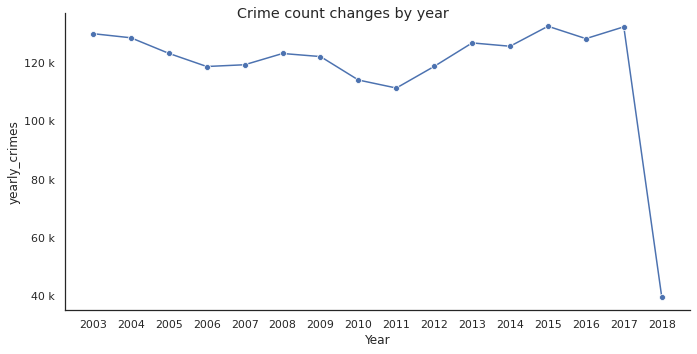

In [0]:
sns.set(style="white")
df = crime_yearly.toPandas()
g = sns.relplot(data=df, x='Year', y='yearly_crimes', kind='line', marker='o', height=5, aspect=2)
g.fig.suptitle('Crime count changes by year')
g.set(xticks=df.Year.values)
for ax in g.axes.flat:
  ax.yaxis.set_major_formatter(tkr.EngFormatter())


###Analysis
The line chart above shows the change of yearly crime counts from 2003 to 2018. 

From the line chart, we can see that:
1. 2015 has the highest crime rate, while 2011 is around the lowest crime rate. 
2. The number of crimes decreased gradually from 2003 to 2011 when it reached the lowest in 2011. 
3. But from 2012 to 2017, the number of crimes rose rapidly. 
4. The crime rate was at a peak in 2015, which may be relevant to *Proposition 47* signed by the governor in the California referendum in 2014 and led to more theft and robbery crimes.

Also, notice that the count in 2018 is far less than other years. It is due to incomplete data with just the first four months in 2018 because SFPD changed to a new dataset. We will look at the monthly count below.

In [0]:
#check the last records of 2018
last = spark.sql("select Date from sf_crime where Year = 2018 and Month = 5 order by Date desc limit 10")
display(last)

Date
2018-05-15
2018-05-15
2018-05-15
2018-05-15
2018-05-15
2018-05-15
2018-05-15
2018-05-15
2018-05-15
2018-05-14


In [0]:
crime_monthly = spark.sql("select count(*) as monthly_crimes, Year, Month from sf_crime group by 2,3 order by 2,3")
#display(crime_monthly)

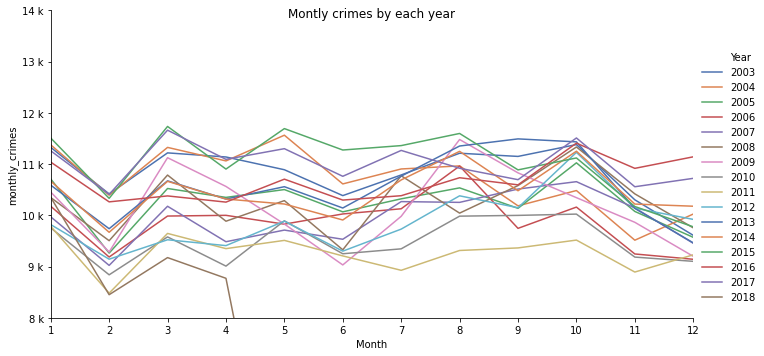

In [0]:
df = crime_monthly.toPandas()
g = sns.relplot(data=df, x='Month', y='monthly_crimes', hue='Year',kind='line',height =5, aspect=2, legend='full',palette='deep')
g.set(ylim=(8000,14000), xlim=(1,12), xticks=range(1,13))
g.fig.suptitle('Montly crimes by each year')
for ax in g.axes.flat:
  ax.yaxis.set_major_formatter(tkr.EngFormatter())

###Analysis
1. As can be seen from the first query above, 2018 only contains complete records for the first four months, and records only updated to 15th in May. Therefore when comparing yearly difference or monthly difference for May-December, 2018 should be left out.

2. From the second plot, we can see that in 2013-2017, the crime rates are above the average of the 15-year range.

3. **Calendar effect:**
January, March, May, August, and October have seen a rise in crimes from the previous month, which may have something to do with one more day in the calendar.  
February has the lowest crime numbers since it has 2 or 3 days fewer than other months.

## 2. number of crimes for different category

In [0]:
crimeCategory = spark.sql("SELECT  category, COUNT(*) AS Count FROM sf_crime GROUP BY category ORDER BY Count DESC")
#display(crimeCategory)

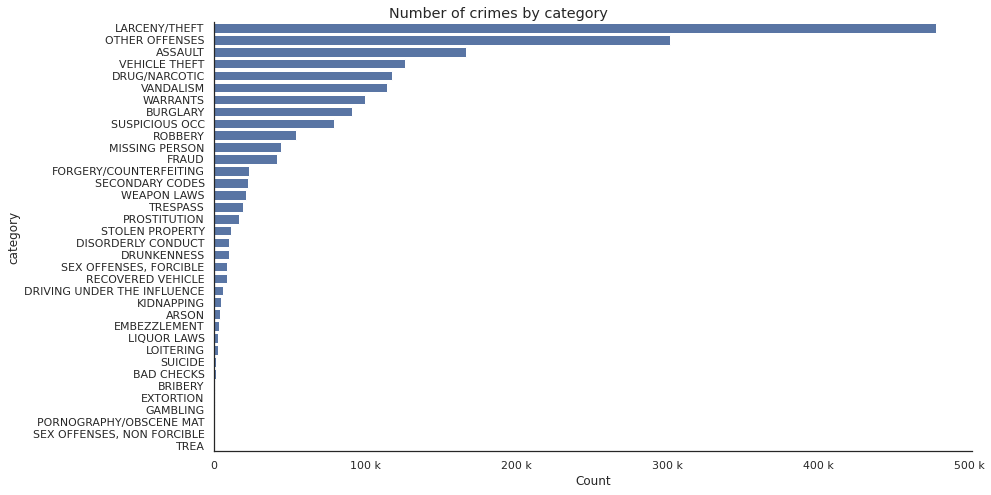

In [0]:
df = crimeCategory.toPandas()
g = sns.catplot(data=df, y='category', x='Count', kind='bar', height=7, aspect=2,color=sns.color_palette()[0])
g.fig.suptitle('Number of crimes by category')
g.fig.subplots_adjust(top=0.95)
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(tkr.EngFormatter())
display(g.fig)

###Analysis
As can be seen from the bar chart, **Larceny/Theft** is the most frequent crime at SF, which is about 60% more than the second category 'Other offenses'.

As mentioned before, *Proposition 47*, the 2014 ballot measure that reclassified nonviolent thefts as misdemeanors if the stolen goods are worth less than $950, had emboldened thieves.

**Other offenses, assault, and vehicle theft** are the second, third, and fourth of the most frequent crimes respectively.

## 3. number of crimes for different district

In [0]:
crime_district = spark.sql("SELECT PdDistrict, count(*) as count from sf_crime group by 1 order by 2 desc")
#display(crime_district)

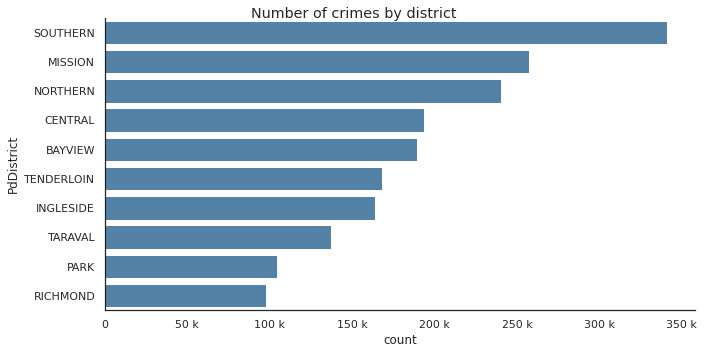

In [0]:
df = crime_district.toPandas()
df = df[df.PdDistrict != 'NA']
g = sns.catplot(data=df,x='count',y='PdDistrict',kind='bar',height=5,aspect=2,color='steelblue')
g.fig.suptitle('Number of crimes by district')
g.fig.subplots_adjust(top=0.95)
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(tkr.EngFormatter())
display(g.fig)

###Analysis
As can be seen from the bar chart:
1. most crimes happened in **Southern district**.  
2. **Mission and Northern district** follows as the second and third place with crime counts similar to each other.  
3. Richmond and Park district have the lowest crime numbers. 

Therefore, when deciding where to live, I would suggest considering those districts with lower crime rates, such as Richmond, and avoiding areas close to the Southern District. If one goes traveling or commuting to places with a higher crime rate, keep a careful watch for potential danger in your surroundings.

## 4. number of crimes each Sunday at "SF downtown".   
SF downtown can be defined via the range of spatial location. For example, you can use a rectangle to define the SF downtown, or you can use a circle with a center as well.  
San Francisco Latitude and longitude coordinates are 37.773972, -122.431297.  
X and Y represent each respectively, so I assume SF downtown as the spacial range: X (-122.4213, -122.4313), Y(37.7540, 37.7740).

In [0]:
crime_Sun_SFdowntown = spark.sql("""
                                 with sunday_downtown_crime as(
                                 select Date    
                                 from sf_crime 
                                 where (DayOfWeek = 'Sunday' 
                                 and X <= -122.4213 
                                 and X >= -122.4313 
                                 and Y >= 37.7540 
                                 and Y <= 37.7740)
                                 )
                                 select Date, count(*) as count
                                 from sunday_downtown_crime
                                 group by 1 
                                 order by 1
                                 """)

#display(crime_Sun_SFdowntown)

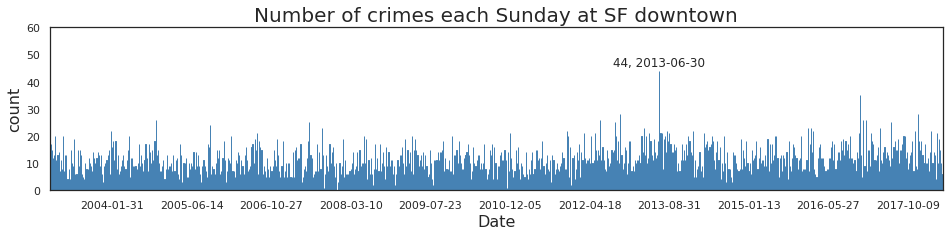

In [0]:
df = crime_Sun_SFdowntown.toPandas()
sns.set(style='white')
fig, ax = plt.subplots(1,1, figsize =(16,3))
ax.bar(df['Date'],df['count'],color='steelblue',edgecolor='steelblue')
ax.set_title('Number of crimes each Sunday at SF downtown',fontsize=20)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=500))
ax.set(xlim=(df['Date'][0],df['Date'].iloc[-1]))
ax.set_ylim(top=60)
ax.set_ylabel('count',fontsize=16)
ax.set_xlabel('Date',fontsize=16)

#label max bar
idx = df['count'].idxmax()
label = str(df['count'].max())+", "+str(df['Date'][idx])
rect = ax.patches[idx]
height = rect.get_height()
ax.text(rect.get_x() + rect.get_width() / 2, 1.01*height, label,
           ha='center', va='bottom',fontsize=12)
plt.show()

## 5. number of crime in each month of 2015, 2016, 2017, 2018.

In [0]:
monthly_crime = spark.sql("""
select Year, Month, count(*) as count from sf_crime
where Year in (2015,2016,2017,2018) group by 1,2 order by 1,2
""")
#display(monthly_crime)

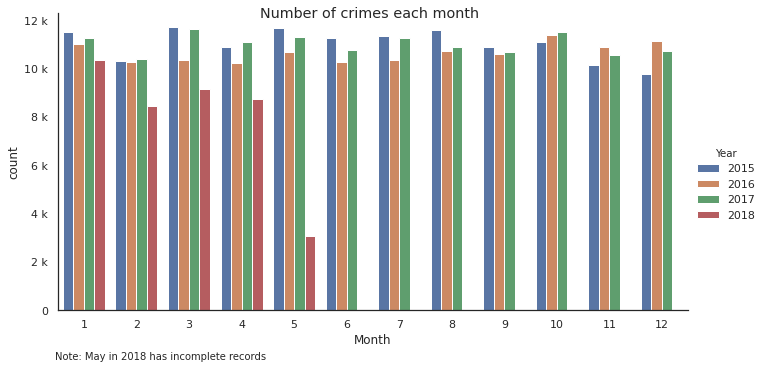

In [0]:
df = monthly_crime.toPandas()
g=sns.catplot(x='Month',y='count',hue='Year',data=df,kind='bar',height=5,aspect=2)
g.fig.suptitle('Number of crimes each month')
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(tkr.EngFormatter())
plt.figtext(0.1,0,'Note: May in 2018 has incomplete records',ha='left',fontsize=10)
plt.show()

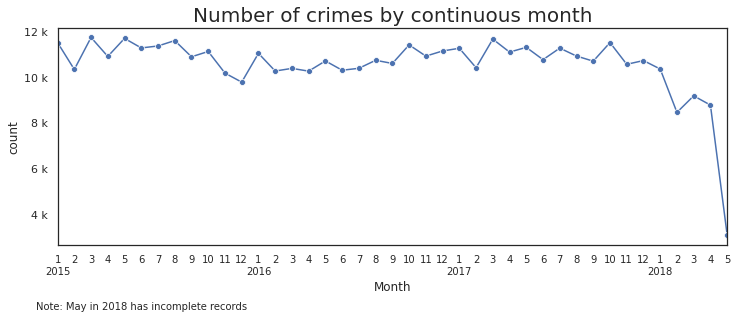

In [0]:
#create an idx column to plot by continuous index order
df['idx']=range(len(df))
g = sns.set(rc={"figure.figsize":(12, 4)})
sns.set(style='white')
g=sns.lineplot(data=df,x='idx',y='count',marker='o')
g.set_xlim(0,len(df)-1)
#define and set x ticks labels
g.set_xticks(df['idx'])
ticks=[]
for x in range(len(df)):
  if df['Month'][x]!=1:
    ticks.append(df['Month'][x].astype(str))
  else:
    ticks.append(df['Month'][x].astype(str)+'\n'+df['Year'][x].astype(str))
g.set_xticklabels(ticks,fontsize=10)
g.set_xlabel("Month")
g.set_title("Number of crimes by continuous month",fontsize=20)
g.yaxis.set_major_formatter(tkr.EngFormatter())
plt.figtext(0.1,-0.1,'Note: May in 2018 has incomplete records',ha='left',fontsize=10)
plt.show()

###Analysis

From the bar chart we can see that:
1. In 2015-2017, January, March, and May have the most crimes.
2. August in 2015, October and December in 2016 and 2017 also have more crimes.

From the line chart, we can see that:
1. Average crime rate from 2015 to 2017 was somehow stable. 
2. It was not until the beginning of 2018 that the crime rate significantly dropped in the first four months. That might suggest a good job done by the SFPD in 2018.

Why are there always more crimes in a certain month besides the fact of more days on the calendar? To answer this question, I took a look at crimes in December and January by date.

In [0]:
crime_Dec = spark.sql("select Year, substring(Date,6,5) as date, count(*) as count from sf_crime where Year in (2015,2016,2017,2018) and Month in (12) group by 1,2 order by 1, 2")
#display(crime_Dec)

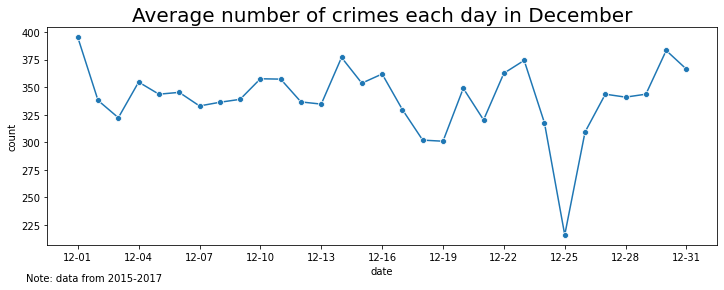

In [0]:
df=crime_Dec.toPandas()
fig=plt.subplots(figsize=(12,4))
ax=sns.lineplot(data=df,x='date',y='count',marker='o',ci=None)
ax.xaxis.set_major_locator(tkr.MultipleLocator(3))
ax.set_title("Average number of crimes each day in December",fontsize=20)
plt.figtext(0.1, 0, 'Note: data from 2015-2017', ha='left',fontsize=10)
plt.show()

In [0]:
crime_Jan = spark.sql("select Year, substring(Date,6,5) as date, count(*) as count from sf_crime where Year in (2015,2016,2017,2018) and Month in (1) group by 1,2 order by 1, 2")
#display(crime_Jan)

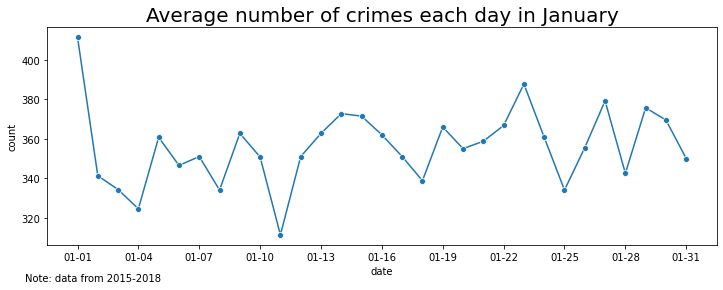

In [0]:
df=crime_Jan.toPandas()
fig=plt.subplots(figsize=(12,4))
ax=sns.lineplot(data=df,x='date',y='count',marker='o',ci=None)
ax.set_title("Average number of crimes each day in January",fontsize=20)
ax.xaxis.set_major_locator(tkr.MultipleLocator(3))
plt.figtext(0.1, 0, 'Note: data from 2015-2018', ha='left',fontsize=10)
plt.show()

###Analysis
From the two line charts above, it seems that days before and on New Year's Day always have the most crimes, which would drop immediately after New Year's Day. There are also the lowest crimes committed on the exact day of Christmas. The period after Christmas until New Year's Day has witnessed a growing number of crimes.

Therefore, during these periods, the police should arrange more force, even though it should be a holiday off. 

*Or: Is it possible that just because most police officers take breaks during this period and thus reduce the police force that the criminals become more active and commit more crimes?*

## 6. travel suggestion to visit SF
Analyze the number of crime w.r.t the hour in certian day like 2015/6/15, 2016/6/15, 2017/6/15.

In [0]:
hourly_crime_certainDay = spark.sql("""
select Date, 
Hour, 
count(*) as count, 
Year
from sf_crime where Date like '%06-15'
group by 4,1,2 order by 1,2
""")
#display(hourly_crime_certainDay)

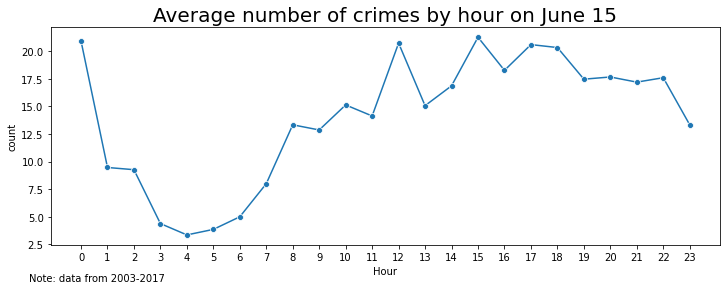

In [0]:
df=hourly_crime_certainDay.toPandas()
fig=plt.subplots(figsize=(12,4))
ax=sns.lineplot(data=df,x='Hour',y='count',marker='o',ci=None)
ax.set_title("Average number of crimes by hour on June 15",fontsize=20)
ax.set(xticks=range(24))
plt.figtext(0.1,0,'Note: data from 2003-2017',ha='left')
plt.show()

###Analysis
The line chart above shows the average hourly crime count on June 15 across the 14 years from 2003 to 2017.

From 2003-2017 counts on average, we can see that on June 15 the highest crime number occurs around ** 12 pm**, and there's an increasing trend starting from ** 1 pm** and reached the second peak around ** 3 pm**.  
There're also fewer crimes in the morning than in the afternoon or evening.  So tourists should better travel in the morning, and should be careful after lunchtime.

*Further thinking:* What type of crime should they watch out for? Is there a difference in the most frequent types of crime across different hours in a day? 

To answer this question, I plot a line chart for each hour showing hourly trends of different types of crime.

In [0]:
hourly_type_certainD = spark.sql("""
select Year, Hour, Date, Category, count(*) as Count
from sf_crime
where Date like '%06-15'
group by 1,2,3,4 
order by 5 desc""")
#display(hourly_type_certainD)

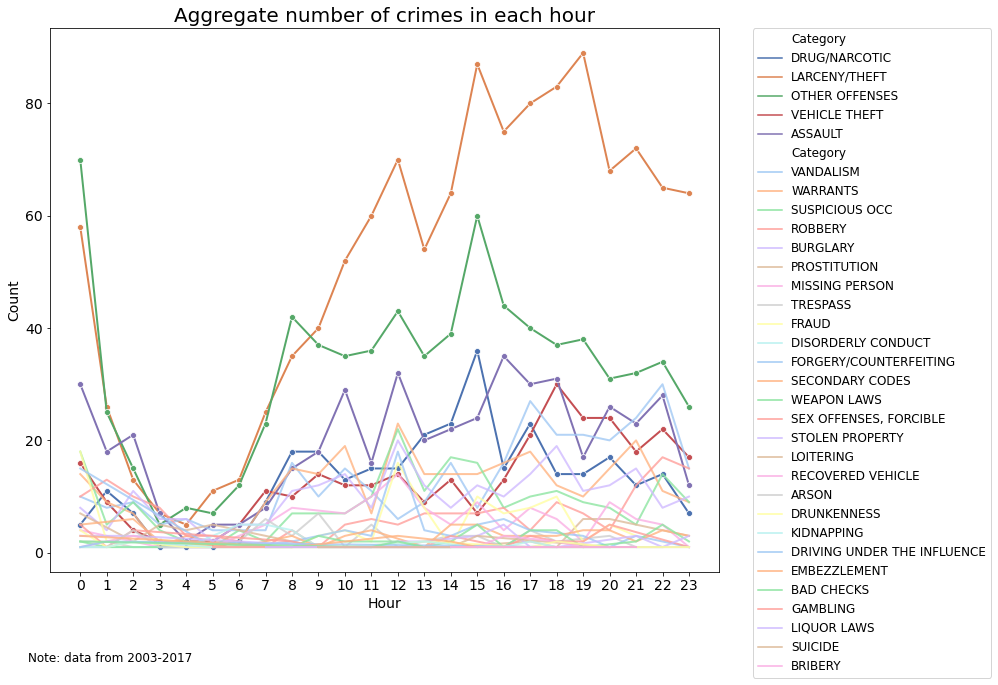

In [0]:
#df=hourly_type_certainD.toPandas()
fig, ax=plt.subplots(figsize=(12,10))
# Plot with emphasis color on most frequent crimes
top=df.Category.unique()[0:5]
line1=sns.lineplot(data=df[df.Category.isin(top)],x='Hour',y='Count',hue='Category',estimator=np.sum, ci=None,palette='deep',marker='o',linewidth=2)
line2=sns.lineplot(data=df[~df.Category.isin(top)],x='Hour',y='Count',hue='Category',estimator=np.sum, ci=None,palette='pastel',linewidth=2,alpha=0.8)
ax.set(xticks=range(24))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_title("Aggregate number of crimes in each hour",fontsize=20)
ax.set_xlabel('Hour',fontsize=14)
ax.set_ylabel('Count',fontsize=14)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.figtext(0.1,0,'Note: data from 2003-2017')
plt.show()

###Analysis

From the above chart, we can see that **Larceny/Theft** is the most frequent crime from around 9 am to 11 pm, while **Other Offenses** is the most frequent crime from 0 am to 8 am. Therefore, if tourists go out at noon, they should be most careful of their belongings.

Notice that not only tourists should be aware of such crimes, but also shop owners as well. The shoplifting epidemic has worsened over the years, which causes so much heavy burden on shop owners that more and more shops have closed because the scale of thefts had made business untenable.  
According to *The New York Times*, these spikes in organized retail crime are only witnessed in San Franciso but not other cities in the state, which implies the problem lies not in California law but mostly on SFPD. The police should provide more support for the shop owners and other local businesses.

## 7. advice to distribute the police
(1) Step1: Find out the top-3 danger disrict  
(2) Step2: find out the crime event w.r.t category and time (hour) from the result of step 1

In [0]:
#step1:
top3_dangerDistrict = spark.sql("select PdDistrict, count(*) as crime_number from sf_crime group by 1 order by 2 desc limit 3")
display(top3_dangerDistrict)

PdDistrict,crime_number
SOUTHERN,340988
MISSION,257385
NORTHERN,240054


In [0]:
#step2:
crime_event = spark.sql("""
select PdDistrict, Category, Hour , count(*) as Count
from sf_crime 
where PdDistrict in ('SOUTHERN', 'MISSION', 'NORTHERN')
group by 1, 2, 3
order by 1, 2, 3
""")
#display(crime_event)

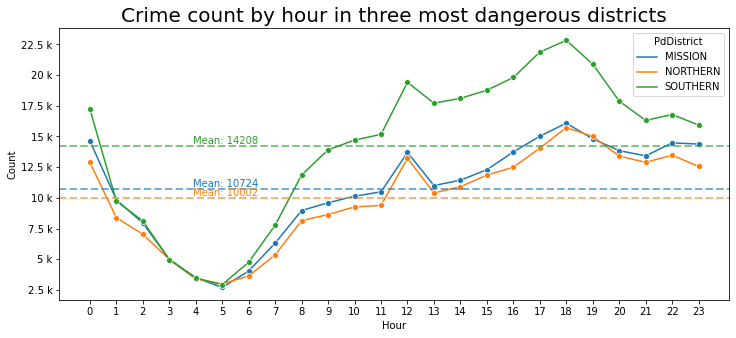

In [0]:
df = crime_event.toPandas()
fig=plt.subplots(figsize=(12,5))
ax=sns.lineplot(data=df,x='Hour',y='Count',hue='PdDistrict',ci=None,estimator=np.sum,marker='o')
ax.set_title('Crime count by hour in three most dangerous districts',fontsize=20)
ax.yaxis.set_major_formatter(tkr.EngFormatter())
ax.set(xticks=range(24))
# Compute average line for each district, add line and annotation
for l in ax.lines:
    y = l.get_ydata()
    if len(y)>0:
      try: 
        ax.axhline(y.mean(), color=l.get_color(),linewidth=2,alpha=.6,linestyle='--')
        ax.annotate(f"Mean: {y.mean():.0f}", xy=(.2,y.mean()+10), xycoords=('axes fraction', 'data'), ha='left', va='bottom', color=l.get_color())
      except:
        pass
        
plt.show()

In [0]:
## This block provides an alternative way to produce the exactly same plot as above:

#df = crime_event.toPandas()
#fig=plt.subplots(figsize=(12,5))
#ax=sns.lineplot(data=df,x='Hour',y='Count',hue='PdDistrict',ci=None,estimator=np.sum,marker='o')
#ax.set_title('Crime count by hour in three most dangerous districts',fontsize=20)
#ax.yaxis.set_major_formatter(tkr.EngFormatter())
#ax.set(xticks=range(24))

## (Here's the difference:)
## 1. Compute average count for each district
#a=df.groupby(['PdDistrict','Hour'],as_index=False).sum()
#a['mean']=a['count'].groupby(a['PdDistrict']).transform('mean')
## 2. Add line and annotation
#ax=sns.lineplot(data=a, x='Hour',y='mean', hue='PdDistrict',legend=False,linewidth=2,alpha=.5,linestyle='--')
#for l in ax.lines[-3:]:
#    y = l.get_ydata()
#    if len(y)>0:
#        ax.annotate(f'Mean: {y.mean():.0f}', xy=(0.2,y.mean()+10), xycoords=('axes fraction', 'data'), ha='left', va='bottom', color=l.get_color())

#ax.set_ylabel('Count')
#plt.show()

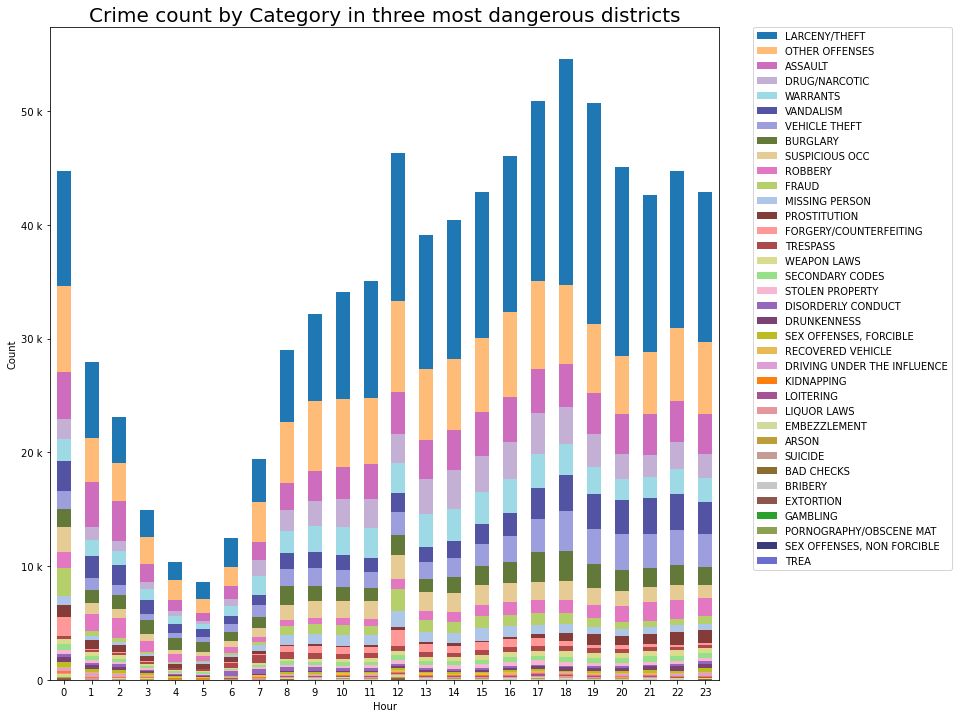

In [0]:
# Prepare data 
stacked_df = df.groupby(['Hour','Category'],as_index=False).sum().fillna(0)
# Make data numerical for stacked plot by pivot function
stacked_df = stacked_df.pivot(columns='Category',index='Hour',values='Count')

# Rearrange layer order by total frequency
rank = df.groupby(['Category'],as_index=False).sum().fillna(0).sort_values(by=['Count'])
order = rank.Category.unique()

# Create new random colormap for better visualization
colors1 = plt.cm.get_cmap('tab20').colors
colors2 = plt.cm.get_cmap('tab20b').colors
newcolors = np.vstack((colors1, colors2))
np.random.seed(0)
np.random.shuffle(newcolors)
cmap = plt.cm.colors.ListedColormap(newcolors)

# Plot by Pandas default stacked plot
ax = stacked_df.loc[:,order].plot(kind='bar', stacked=True, figsize=(12,12), colormap=cmap, rot=0)
ax.set_title('Crime count by Category in three most dangerous districts', fontsize=20)
ax.yaxis.set_major_formatter(tkr.EngFormatter())
ax.set_ylabel('Count')
# Move the legend out of the figure and reverse legend order by descending
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1],loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.show()

###Analysis

The top 3 dangerous districts are **Southern, Mission** and **Northern**.



*Here I assume that the SF police force is arranged as a whole and each district also has some of its own force, so we need to distribute force across **districts** for SFPD, as well as across **hours** for each district's police office.*

From the bar charts above we can see that:
1. The highest number of crimes occurs at ** 6 pm** and ** 12 pm**. 
2. The 5 most frequent crimes in three district are **larceny/theft, other offenses, assault, drug/narcotic and warrants**, which accounts for over half of the crimes occurred in each hour.
3.  In the **Southern district**, the period ** 11 am - 12 am** has a crime count above the average of a day within that district.  
In **Mission district**, the period is **11am - 12am**.  
In **Northern district**, the period is **12pm - 12am**.  

In conclusion, more police force should be distributed to these districts during these periods. 

- *See also: [an interactive stacked bar chart](https://public.tableau.com/app/profile/zishan.cheng/viz/sf_crimetop3districthourlycrimecategory/Sheet1?publish=yes) by hour and category in each district created by Tableau to play around.*

## 8. hints to adjust policy on different type of crime
For different category of crime, find the percentage of resolution.

In [0]:
%sql select distinct(resolution) as resolve from sf_crime

resolve
EXCEPTIONAL CLEARANCE
"ARREST, BOOKED"
PROSECUTED FOR LESSER OFFENSE
LOCATED
UNFOUNDED
DISTRICT ATTORNEY REFUSES TO PROSECUTE
PSYCHOPATHIC CASE
COMPLAINANT REFUSES TO PROSECUTE
"ARREST, CITED"
PROSECUTED BY OUTSIDE AGENCY


There are 12 types of resolution conditions for all incident reports, in which **'None'** means unresolved.

In [0]:
# Count total incidents by Category and create SQL table 'crime_total'
crime_total = spark.sql("select Category, count(*) as total from sf_crime group by Category order by 2 desc")
crime_total.createOrReplaceTempView("crime_total")
display(crime_total.limit(3))
crime_total.cache()

Category,total
LARCENY/THEFT,477975
OTHER OFFENSES,301874
ASSAULT,167042


Out[6]: DataFrame[Category: string, total: bigint]

In [0]:
# Count total resolved incidents by Category and create SQL table 'crime_res'
crime_res = spark.sql("select Category, count(*) as resolved from sf_crime where Resolution != 'NONE' group by 1")
crime_res.createOrReplaceTempView("crime_res")

# Calculate and sort resolution rate by category
resolve_rate = spark.sql("select a.Category, resolved, total, resolved/total as percentage from crime_total a left join crime_res b on a.Category = b.Category order by percentage desc")
display(resolve_rate.limit(3))

Category,resolved,total,percentage
PROSTITUTION,15651,16501,0.9484879704260348
WARRANTS,94339,99821,0.9450816962362629
DRIVING UNDER THE INFLUENCE,5335,5652,0.9439136588818118


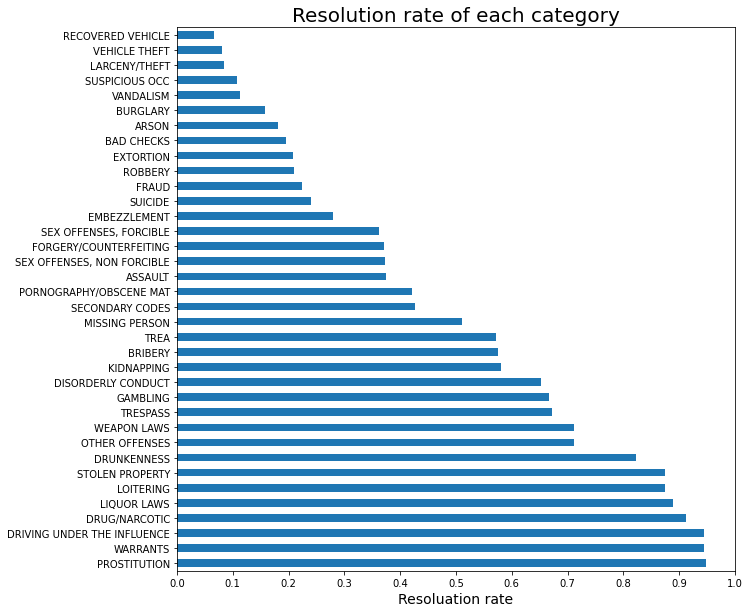

In [0]:
df = resolve_rate.toPandas()
ax = df.plot(y='percentage',x='Category',kind='barh',figsize=(10,10),legend=False)
ax.set_title('Resolution rate of each category',fontsize=20)
ax.set(xticks=np.linspace(0,1,11))
ax.set_xlabel('Resoluation rate',fontsize=14)
ax.set_ylabel('')
plt.show()

###Analysis 
From the bar chart, we can see that **prostitution, warrants**, and **driving under the influence** have the **highest resolution rates** among all 36 categories, with resolution rates above 94%.  
However, from the other side of the bar chart, we can see that **recovered vehicle, vehicle theft, larceny/theft** has **the lowest resolution rate below 10%**, followed by **suspicious OOC** and **vandalism**, with resolution rates both **below 15%**. 

Why are so many of these types of crimes remain unresolved? Is it due to a lack of police capability or legal restrictions on these types? I think that both parties should answer this question.  
- For the police department, I suggest they investigate those unresolved cases to see if there's a problem of laissez-faire attitude or ability. If there's a downplay on those cases, for example, taking it for granted that theft is hard to traced and thus making no effort to resolve it, then the police should rectify the situation. If there's a need for applying advanced techniques or skills, the department in charge should fix it.  
- As for the policymakers, I suggest they investigate the motivation behind those crimes. If there's a difficulty for the police to resolve those cases (for either reason), then it would be best to prevent the crime before it happens by adjusting relevant policies.  

Notice that **larceny/theft** is the most frequent crime, **vandalism** at 7th place, **vehicle theft** at 8th.  More emphasis should place on these categories with the least resolution rate to enhance the police's technique/skills for solving such crimes or enforce more restrictions/punishments on those crimes.

Now let's take a look at the percentage of resolutions in detail by category:

In [0]:
# Count and compute percentage and sort each resolution type by category
resolve = spark.sql("""
with resolve as (select Category, resolution, count(*) as count
from sf_crime group by 1,2)
select a.Category, a.resolution, a.count, b.total, a.count/b.total as percentage
from resolve a 
left join crime_total b
on a.Category = b.Category 
order by b.total desc, a.count desc
""")
#display(resolve)

In [0]:
## 1. Manipulate data for plotting: because I only want to plot the top 3 resolutions and a sum of the rest cases(if available) in each donut chart for better visualization 
df = resolve.toPandas()
# Compute the sum and percentage of other cases except top 3 resolutions in each category as 'OTHERS'
others = df.groupby('Category')['count'].transform(lambda x: x[3:].sum())
percentage = df.groupby('Category')['percentage'].transform(lambda x: 1-x[:3].sum())
# Create a copy dataframe with only top 3 resolutions in each category
new_df = df.groupby('Category',as_index=False).head(3).copy()
# Get index of the desired row to insert 'OTHERS' (i.e. the forth row in each category if available)
index = df.groupby('Category',as_index=False).nth(3).index
# Insert the new row of 'OTHERS' into dataframe
for i in index:
  #columns: [Category, resolution, count, total, percentage]
  new_df.loc[i] = [df.Category.loc[i], 'OTHERS', others.loc[i], df.total.loc[i], percentage.loc[i]] 
new_df = new_df.sort_index()

In [0]:
# Take a look at the manipulated dataframe: notice the new resolution 'OTHERS'; the sum of 'count' equals 'total' in each category
new_df.head(8)

Out[91]:

,Category,resolution,count,total,percentage
0,LARCENY/THEFT,NONE,437927,477975,0.916213
1,LARCENY/THEFT,"ARREST, BOOKED",25136,477975,0.052589
2,LARCENY/THEFT,"ARREST, CITED",10463,477975,0.021890
3,LARCENY/THEFT,OTHERS,4449,477975,0.009308
12,OTHER OFFENSES,"ARREST, BOOKED",115427,301874,0.382368
13,OTHER OFFENSES,"ARREST, CITED",94817,301874,0.314095
14,OTHER OFFENSES,NONE,86815,301874,0.287587
15,OTHER OFFENSES,OTHERS,4815,301874,0.015950


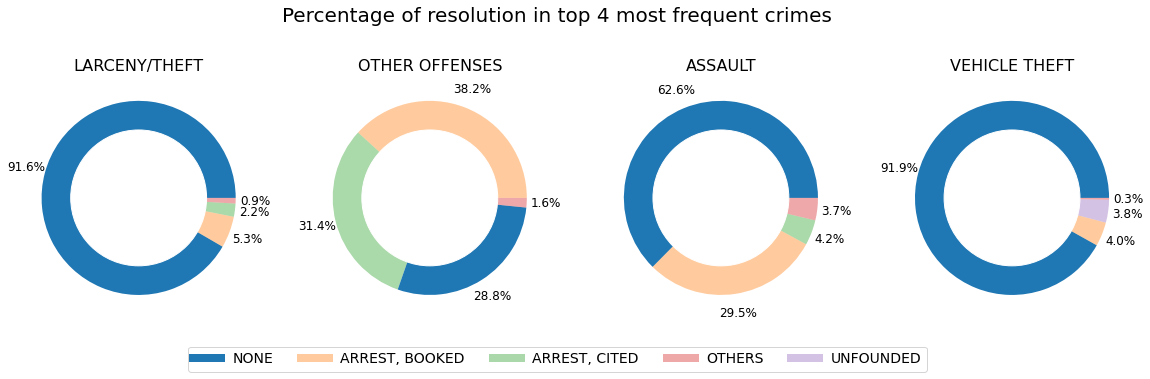

In [0]:
fig, axes=plt.subplots(1,4,figsize=(20,5))
fig.suptitle('Percentage of resolution in top 4 most frequent crimes',fontsize=20, va='bottom')
rank = new_df.Category.unique() 
# Set consistent colormap across subplots
resolutions = new_df.loc[df['Category'].isin(rank[:4])].resolution.unique() #get values from top 4 crimes
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color'] #get default color cycler
colors = {resolutions[i]: f'{cycle[i]}66' for i in range(len(resolutions))} #note: adjust hex color value to 66 for 40% alpha
colors['NONE'] = 'C0' #change the highlight wedge color back to 100% alpha 

# Plot the top 4 category
for i in range(4): 
  dff = new_df.loc[df['Category']==rank[i]]
  axes[i].pie(dff['percentage'],autopct='%0.1f%%',pctdistance=1.2, textprops={'fontsize': 12}, colors=[colors[key] for key in dff['resolution']])
  centre_circle = plt.Circle((0,0),0.7,color='white', fc='white')
  axes[i].add_artist(centre_circle)
  axes[i].set_title(rank[i],fontsize=16)
  
# Custom fake lines for global legend
markers = [plt.Line2D([0,0],[0,0],color=color,lw=8) for color in colors.values()]
#plt.legend(markers, colors.keys(), numpoints=1)
fig.legend(markers, colors.keys(), ncol=len(markers), loc='lower center', bbox_to_anchor=(0.5,0),bbox_transform=fig.transFigure,prop={'size': 14})

plt.show()  

###Analysis
Although there's a critique over donut/pie charts, I think there are no consistently superior charts over any other. It depends on specific situations.  
In this particular case, I observe that donut charts work best than any other charts like stacked bars, side-by-side bars, or treemap in showing that **the unresolved have a majority over all resolutions** in each category.

The pie chart above demonstrates the resolution condition in detail of the top four most committed crimes to provide more direct visualization comparing crime numbers and resolution rate.  
As can be seen, the resolution rate is shockingly low for these most frequent crimes, with **more than 60% of incidents unresolved** in three of the four most frequent crimes.  
So there's an urgent need to improve this situation.

## Conclusion of Part 1

###1. Motivation

When considering whether to reside in a place or not, one of the most critical factors is to research the safety and crime rate of the area. Most people would prefer a safer place to live, especially for a mid- or long-term residence or someone who plans to run their own business.  
Almost every new UC Berkeley student coming from another area must have heard about the safety concerns around the campus: drugs, homeless people, etc. As an international student from even another country, I remembered the feeling of anxiety and uncertainty over the potential safety issue in Berkeley.   
I thought it would be helpful to analyze crime data of a city in an attempt to understand what's going on around this place, how residents/tourists/shop owners stay cautious, and how to improve the police force by further enhance relevant policies. I chose SF for this crime analysis project because it is a world-famous metropolis with a population of over 880K, and it is also one of my favorite cities.

###2. Methods

1) Data processing

  To begin with, to perform analysis on SF crime data from 2003-2018 of large size of more than 551MB, I utilized **Spark SQL** to load and manipulate the dataset. 

  The reason is that Spark offers a parallel method to process the data and thus leads to a much faster-running speed than using Python pandas or Hadoop. **Spark SQL can directly read from multiple sources and ensures fast execution of existing Hive queries**. Moreover, **SQL can provide an easy way to load data without checking the many APIs from PySpark**, so it is good to get started. **After using Spark SQL to query data, I can use PySpark to load and transform the data and train the machine learning model later.**  
On deciding to use Spark SQL instead of the PySpark DataFrame method, I compared the performance of both methods and noticed that SQL was faster.

2) Data visualization

  After data cleaning and processing, I utilized **seaborn, matplotlib, pyplot** for visualization and **Tableau** for more advanced demonstration purposes. I selected the features of interest such as categories, time, districts of crimes to visualize for better understand and analyze the potential properties and relations among different factors. 
  
  I also chose the most suitable form of a plot from various types to fulfill the analysis need.  
 -  For example, I used **grouped line charts of hour vs crime numbers grouped by different districts and category, to display clearly the variation of crime rate within a day and easily compare across groups**. I also added an annotation line of grouped mean values in each district for interpretation.  
 -  I also used **donut charts of the percentage of resolution in each crime category and sorted by crime frequency, showing clearly the resolution condition of the most frequent crime**.  
 -  When displaying the crime event w.r.t category and time (hour) in the top 3 dangerous districts, I plotted a **stacked bar chart so that it is easy to compare the hourly difference of number and type of crimes**.
  
Selecting the best type and style for visualization makes a huge difference and is essential in conveying the insights from data analysis results.

###3. Analysis and insights
1. From the bar chart and line chart of crime count in 2015-2018, I noticed a decreasing crime in 2018. From the line chart of 15 years, I found an increasing trend of crime count since 2011, but the first four months of 2018 have the lowest number of crimes over the years.

2. From the bar chart of hourly crime count of different categories, and line plot of hourly crime count in a day, I found that most crimes occur during lunch or in the afternoon in 4-8 pm, and early morning has the least amount of crime, especially in 1-7 am. So it is suggested to travel in the morning and assign more police in the evening.

3. From the bar chart and pie chart of categories vs resolution rate, Prostitution, Warrants, and Driving under Influence are the most resolved, while Recovered vehicle, Vehicle theft, and Larceny/theft are the least resolved. Moreover, some categories with the lowest resolution rate are also the most frequently occurred, which should be fixed urgently and paid more effort and attention to by the police and policymakers.

# Part 2: Clustering

In this part, I conducted **unsupervised learning for spatial data analysis** to help SFPD to distribute and arrange their force and officers. I applied the **Spark ML clustering algorithm** to cluster the spatial data, then visualize and analyze the clustering results.   

In particular, I use two clustering algorithms: [**K-means**](https://spark.apache.org/docs/latest/ml-clustering.html#k-means) and [**bisecting K-means**](https://spark.apache.org/docs/latest/ml-clustering.html#bisecting-k-means) to find the K centers where crimes occur frequently.  
I also used **two evaluation metrics**: [the Silhouette](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.ClusteringEvaluator.html?highlight=clusteringevaluator#pyspark.ml.evaluation.ClusteringEvaluator) using the squared Euclidean distance, and the training cost.  
- **Silhouette score** is a measure for the validation of the consistency within clusters. It ranges between 1 and -1. A value close to 1 means that clusters are well apart from each other and clearly distinguished. 0 means clusters are indifferent (i.e., the distance between clusters is not significant). -1 means clusters are assigned in the wrong way.   
(*Further reading: [wiki on how to compute silhouette score](https://en.wikipedia.org/wiki/Silhouette_%28clustering%29)*)
- **Training cost** is the sum of squared distances to the nearest centroid for all points in the training dataset. This is equivalent to sklearn's inertia, or within-cluster sum-of-squares criterion.



For the crimes of interest, I chose **two categories for analysis**: larceny/theft and robbery. Because I assumed they might have spatial attributes of occurrence. I came up with several assumptions of possible occurrence clusters.
- Theft may occur most frequently in wealthy residential areas or business districts for valuable targets; or dangerous places or tourists attractions for easier success.
- Robbery may be more likely to appear at dangerous places, places near businesses, tourist attractions, or places where gang forces are active.  

The **spatial analysis is very important** for SFPD to arrange their force.  
- If there are too few districts divided, the police department may not be efficient and has slow response speed because the range is too far for police officers to arrive at the scene. i.e., too spatial region for only a fixed number of available officers. 
- On the other hand, if increasing the number of responsible districts but not divide reasonably, some districts may have crimes occur too frequently, while some may have too few, so it's more likely to misarrange the police and causes a waste of force.  
- If correctly dividing the responsible regions, better efficiency, fast response speed, reasonable incident-to-staff ratio, and workload could be ensured and may increase resolve rate eventually.

In the following part, I will present the analysis of the final results first, then a walk-through of the code.

##2.1 Spatial analysis on larceny/theft
Here I displayed the best three models from 38 models in total and arranged them in the **decreasing silhouette from left to right**. The **map background is the current police districts.**

![cluster results of theft](https://github.com/zcheng233/SF-crime-analysis-in-Apache-Spark/blob/main/clustering_on_theft.png?raw=true)
[*See origin: interactive plot in Tableau*](https://public.tableau.com/app/profile/zishan.cheng/viz/Clusteringonlarcenytheftincidentskmeansk3kmeansk8bisectingkmeansk4/Sheet2?publish=yes)

The first model has three clusters with the **highest silhouette score** of 0.58 and cost = 100.78. We can see that red cluster 1 covers Mission, Bayview, and Ingleside districts; the orange cluster 2 covers Richmond, Park, Taraval, and left half of Northern district; the blue cluster 3 covers Southern, Tenderloin, Central, and right half of Northern.  
So it seems that the current police districts are in line with the k-means clusters, except that the Northern district might need some further consideration. However, **we might still want more clusters to enhance efficiency with the limited police force**.

The second model has eight clusters with the **lowest training cost** = 41.61 and silhouette = 0.50. This model also has an advantage over the first one in terms of **more subdivided regions that might help increase police response speed and shorten the time to arrive at the scene**.

The third model is similar to the first one with silhouette = 0.47 and cost = 86.19, also in line with the current boundaries of police districts. The main difference is that it divides the bottom part into two clusters from the middle, making Bayview and Southern district a new cluster 4.

##2.2 Spatial analysis on robbery
Here I displayed the best four models from 38 models in total and arranged them in the **decreasing silhouette from left to right**. The **map background is the current police districts**.

![clusteronrobbery](https://raw.githubusercontent.com/zcheng233/SF-crime-analysis-in-Apache-Spark/main/clustering_on_robbery.png)
[*See origin: interactive plot in Tableau*](https://public.tableau.com/app/profile/zishan.cheng/viz/clusteringonrobberyincidents/Sheet1?publish=yes)

The first model has only two clusters with the **highest silhouette** = 0.72 and cost = 18.855124533176422. It cuts the clusters in the middle and divides them into top and bottom halves. 

The second model has 6 clusters with the **lowest cost** = 6.27 and silhouette = 0.64. It is **finer divided and has smaller clusters for increasing efficiency**. It also **works well with the current district's boundaries and thus is more applicable in reality**.  

The third model has 4 clusters with a silhouette = 0.58 and cost = 10.08. It cuts in the middle horizontally to the top and bottom parts, then cuts vertically to halve each part. Similar to the first model, it doesn't quite in line with police district boundaries.

The fourth model has 3 clusters with silhouette = 0.57 and cost = 14.20. It also cuts horizontally with arbitrary boundaries.


I would recommend the second one for its good evaluations and in line with current boundaries.

## 2.3 Comparison 
Compared with larceny/theft, robbery has fewer clusters in best models, which may imply a more focused center in occurrence distribution.  
It also reached a higher silhouette score and lower training cost (inertia), meaning that clustering models are more reliable in terms of robbery incidents. This may imply hot spots of organized robbery by regional crime groups. Theft somehow contains more randomness and is less organized, as can be implied from its lower silhouette score.

##2.4 Walk-through clustering

###1. Data preprocessing
For spatial insights, I used **latitude (Y) and longitude (X) for clustering**. I also selected other vectors not for training but reference information or in case of further analysis.  
I defined a function **`cluster_data`** that requires the user to input the SF crime dataframe, the category of crime of interest, and the columns to keep.  
It **transforms the latitude and longitude into the correct data type (float), removes outliers by the rule of Interquartile Range (IQR), and assembles vectors for conducting clustering in Spark**.  
The return is a Spark dataframe that can use for later steps.  

Notice that I did not standardize the vectors as suggested in most clustering cases, because in the case of geographic data of latitude and longitude, standardization will cause distortion.

In [0]:
# select needed columns
cols = ['IncidntNum', 'Category','PdDistrict','Resolution','X','Y','location']
## Prepare features
def cluster_data(dataset, category, cols):
  # Loads data.
  df = dataset.select(cols).where(sf_crime.Category==category)
  #1.change data type
  FEATURES_COL = ['X', 'Y']
  for column in df.columns:
      if column in FEATURES_COL:
          df = df.withColumn(column,df[column].cast('float'))
  #2.filter by quantiles and drop outlier
  bounds = {
    c: dict(zip(["q1", "q3"], df.approxQuantile(c, [0.25, 0.75], 0)))
    for c in df.select(['X','Y']).columns
  }
  for c in bounds:
    iqr = bounds[c]['q3'] - bounds[c]['q1']
    bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
    bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)  
  df = df.select('*').where(col("X").between(bounds['X']['lower'], bounds['X']['upper'])).where(col("Y").between(bounds['Y']['lower'], bounds['Y']['upper']))
  #3.assemble vector for clustering in spark
  vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
  df_t = vecAssembler.transform(df)
  return df_t

df_t = cluster_data(sf_crime, 'LARCENY/THEFT', cols)
df_r = cluster_data(sf_crime, 'ROBBERY', cols) #robbery

###2. Tuning K
After getting the data ready for training, the next step is to tune the hyperparameter of k. I defined a function **`cluster_opt`** to help **optimize the choice of k by plotting the test score of Silhouette and training cost**.  
- The user inputs the dataframe returned from `cluster_data`, choose a training algorithm from K-means `method='kmeans'` (by default) or Bisecting K-means `method='bkm'`, and defines the tuning range by inputs `k_tune` (20 by default).  
- The function will then train the model with the selected algorithm **for k in range(2, `k_tune`)**, so the largest k available will be `k_tune` - 1. The training is on a **subset of sample data to increase efficiency** because our data is too large. This sampling approach is guaranteed by LLN.   
- After each training, the model will be **evaluated on the full dataset by the Silhouette score and training cost**. The values of metrics for each model are saved separately and will be returned. Elbow plots will also output automatically.   
In clustering, it's not necessary to split data into train, test, or validation sets, because the purpose of clustering and other unsupervised learning is to find insights directly from data (instead of classification).

There are some concerns about applying K-means in geospatial clustering. Some argue that [K-means is not appropriate](https://datascience.stackexchange.com/questions/761/clustering-geo-location-coordinates-lat-long-pairs) in this case because of the problem of measuring geographic distance. But since I only used the geolocation in SF (which is a very limited region on the globe), K-means should be harmless. Moreover, there's an ongoing discussion on how to choose the *right* clustering algorithm, so it's just fine to use any model you find reasonable.

In [0]:
## Optimize choice of k and plot test score
def cluster_opt(dataset, method='kmeans', k_tune=20):
  alg = {'bkm':BisectingKMeans(),'kmeans':KMeans()}
  silhouette = np.zeros(k_tune)
  cost = np.zeros(k_tune)
  evaluator = ClusteringEvaluator()
  for k in range(2,k_tune):
      # train a k-means model on sample subset
      train = alg[method].setK(k).setSeed(1).setFeaturesCol("features")
      model = train.fit(dataset.sample(False, 0.1, seed=42))
      # Make predictions
      predictions = model.transform(dataset)
      # Evaluate clustering by training cost (sum of squared distances of points to their nearest center)
      cost[k] = model.summary.trainingCost
      # Evaluate clustering by computing Silhouette score
      silhouette[k] = evaluator.evaluate(predictions)
      # if spark below 3.0.0: Evaluate clustering by computing Within Set Sum of Squared Errors 
      #cost[k] = model.computeCost(df_t)
      
  #plot test score
  title = 'testing score of %s' % method
  fig, ax = plt.subplots(1,2, figsize =(12,3))
  fig.suptitle(title, fontsize=20, va="bottom")
  #silhouette
  ax[0].plot(range(2,k_tune),silhouette[2:k_tune],marker='o')
  ax[0].set(xticks=range(2,k_tune))
  ax[0].set_xlabel('k',fontsize=20)
  ax[0].set_title('silhouette',fontsize=20)
  #cost
  ax[1].plot(range(2,k_tune),cost[2:k_tune],marker='o')
  ax[1].set(xticks=range(2,k_tune))
  ax[1].set_xlabel('k',fontsize=20)
  ax[1].set_title('training cost',fontsize=20) 
  plt.show()
      
  return silhouette, cost

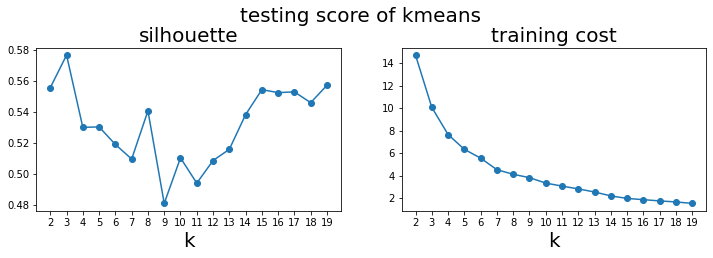

In [0]:
#tuning k-means clustering on theft data   
silhouette_t, cost_t = cluster_opt(df_t)

From the results of **K-means on larceny/theft**, I chose best **k=3** for the highest silouette score and **k=8** for turning point of training cost and a high silhouette.

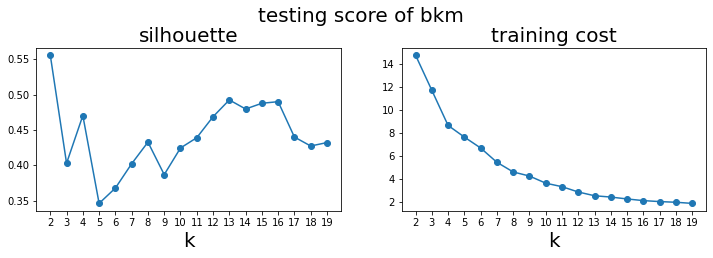

In [0]:
# tuning bisecting k-means on theft data
silhouette_tb, cost_tb = cluster_opt(df_t, method='bkm')

From the results of **bisecting K-means on larceny/theft**, I chose **k=4** with a high silhouette and turning point of the training cost for the tradeoff between silhouette and training cost.

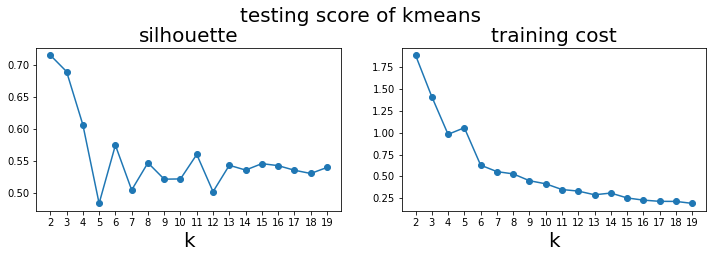

In [0]:
# tuning k-means on robbery data
silhouette_r, cost_r = cluster_opt(df_r)

From the results of **K-means on robbery**, though k=2 has the highest silhouette, I chose **k=3** for a similar silhouette but much less training cost, and **k=6** for turning point of traning cost.

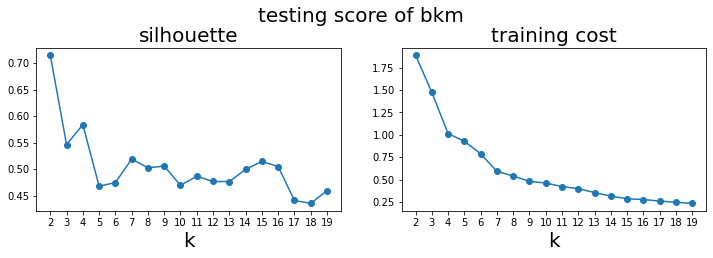

In [0]:
# tuning bisecting k-means on robbery data
silhouette_rb, cost_rb = cluster_opt(df_r, method='bkm')

From the results of **bisecting K-means on robbery**, I chose **k=2** for highest silhouette and **k=4** for the second silhouette and much less training cost.

###3. Train the model with the best k value
I defined a function **`cluster_best` for training the best model and plotting predictions**. 
Similar to `cluster_opt` for tuning, the user inputs dataset, clustering algorithm, and `best_k` for the best k value. 
The function will return the model and predictions, and print the silhouette and training cost.  
By default, it will also automatically output visualization of predictions with `plot=True`. Since there is too much data, I only plot a random sample of 500 points for a clear vision and efficiency.

I also defined a separate function **`cluster_plot` for visualization**, so the user can input an already trained model (for getting centroids) and predictions to get the same plots.

In [0]:
def cluster_best(dataset, best_k, method='kmeans',plot=True):
  alg = {'bkm':BisectingKMeans(),'kmeans':KMeans()}
  best_train = alg[method].setK(best_k).setSeed(1).setFeaturesCol("features")
  model = best_train.fit(dataset)
  predictions = model.transform(dataset)
  evaluator = ClusteringEvaluator()
  print('Silhouette=', evaluator.evaluate(predictions))
  print('Cost=', model.summary.trainingCost)  
  
  # plot
  if plot:
    predictions_pd = predictions.drop('features').toPandas()
    centers = model.clusterCenters()
    fig = plt.figure(figsize =(12,3))
    fig.suptitle('cluster sample', fontsize=20, va="bottom")
    #before
    ax0=fig.add_subplot(121)
    sns.scatterplot(data=predictions_pd.sample(n=500, random_state=42),x='X',y='Y')
    #after
    ax1=fig.add_subplot(122)
    sns.scatterplot(data=predictions_pd.sample(n=500, random_state=42), x='X',y='Y',hue='prediction',legend='full',palette='tab20')
    #add centers
    sns.scatterplot(x=np.array(centers)[:,0], y=np.array(centers)[:,1],s=200,hue=range(len(centers)),legend=False,edgecolor='black',linewidth=1.7,palette='tab20')
    plt.legend(loc='upper left', bbox_to_anchor=(1.01,1))
    plt.show()
    
  return model, predictions


In [0]:
#this is a separate plotting function
def cluster_plot(model, predictions):
  predictions_pd = predictions.drop('features').toPandas()
  centers = model.clusterCenters()
  fig = plt.figure(figsize =(12,3))
  fig.suptitle('cluster sample', fontsize=20, va="bottom")
  #before
  ax0=fig.add_subplot(121)
  sns.scatterplot(data=predictions_pd.sample(n=500, random_state=42),x='X',y='Y')
  #after
  ax1=fig.add_subplot(122)
  sns.scatterplot(data=predictions_pd.sample(n=500, random_state=42), x='X',y='Y',hue='prediction',legend='full',palette='tab20')
  #plot centers
  sns.scatterplot(x=np.array(centers)[:,0], y=np.array(centers)[:,1],s=200,hue=range(len(centers)),legend=False,edgecolor='black',linewidth=1.7,palette='tab20')
  plt.legend(loc='upper left', bbox_to_anchor=(1.01,1))
  plt.show()


####3.1 Theft/larceny

Silhouette= 0.5765190578563055
Cost= 100.77966348745873

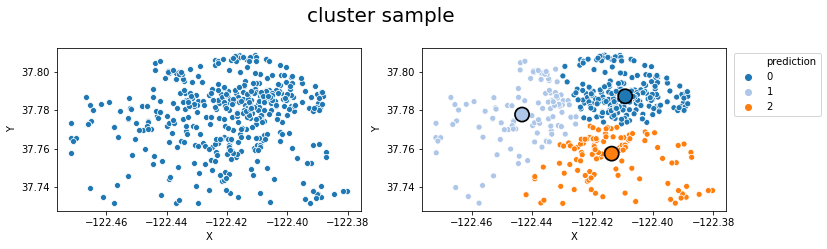

In [0]:
# K-means, k=3
mk3t, pk3t = cluster_best(df_t,3)

In [0]:
# To download the sample data from databricks for plotting in Tableau
#display(pk3t.drop('features').toPandas().sample(n=500, random_state=42))

Silhouette= 0.4953141652543126
Cost= 41.610109272652345

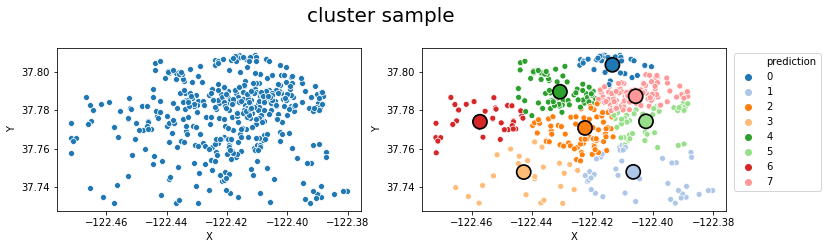

In [0]:
# K-means, k=8
mk8t, pk8t = cluster_best(df_t,8)

In [0]:
#display(pk8t.drop('features').toPandas().sample(n=500, random_state=42))

In [0]:
# Bisecting K-means, k=4
mb4t, pb4t = cluster_best(df_t,4,method='bkm',plot=False)

Silhouette= 0.4718500724954762
Cost= 86.19099843502045

In [0]:
#display(pb4t.drop('features').toPandas().sample(n=500, random_state=42))

As we can see, the visualization in Python is hard to further interpret without map and geographic information. Therefore, I download the sample predictions to plot in Tableau. Below is a screenshot for the [Tableau visualization of clustering results of larceny/theft](https://public.tableau.com/app/profile/zishan.cheng/viz/Clusteringonlarcenytheftincidentskmeansk3kmeansk8bisectingkmeansk4/Sheet2?publish=yes).

![cluster results of theft](https://github.com/zcheng233/SF-crime-analysis-in-Apache-Spark/blob/main/clustering_on_theft.png?raw=true)

#### 3.2 Robbery

In [0]:
#K-means, k = 3
mk3r, pk3r = cluster_best(df_r, 3,plot=False)

Silhouette= 0.5653087631995269
Cost= 14.197570696594568

In [0]:
#display(pk3r.drop('features').toPandas().sample(n=500, random_state=42))

In [0]:
# K-means, k=6
mk6r, pk6r = cluster_best(df_r, 6,plot=False)

Silhouette= 0.6467808147216206
Cost= 6.266090180653721

In [0]:
#display(pk6r.drop('features').toPandas().sample(n=500, random_state=42))

In [0]:
# Bisecting K-means, k=2
mb2r, pb2r = cluster_best(df_r,2,method='bkm',plot=False)

Silhouette= 0.715271310459117
Cost= 18.855124533176422

In [0]:
#display(pb2r.drop('features').toPandas().sample(n=500, random_state=42))

In [0]:
#Bisecting K-means, k=4
mb4r, pb4r = cluster_best(df_r,4, method='bkm',plot=False)

Silhouette= 0.5826394054635564
Cost= 10.078367680311203

In [0]:
#display(pb4r.drop('features').toPandas().sample(n=500, random_state=42))

Below is a screenshot for the [Tableau visualization of clustering results of robbery](https://public.tableau.com/app/profile/zishan.cheng/viz/clusteringonrobberyincidents/Sheet1?publish=yes).
![clusteronrobbery](https://github.com/zcheng233/SF-crime-analysis-in-Apache-Spark/blob/main/clustering_on_robbery.png?raw=true)